Frame Number :  1


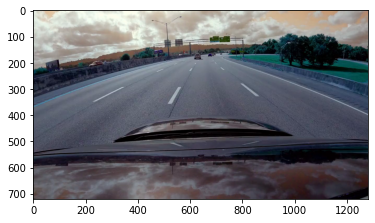

Color Segmentation


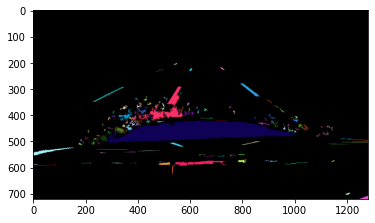

Frame with motion object detection without background


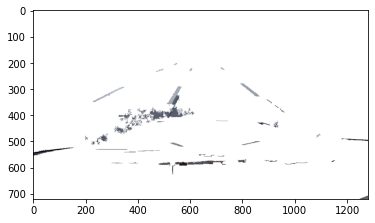

Frame with motion object detection with background


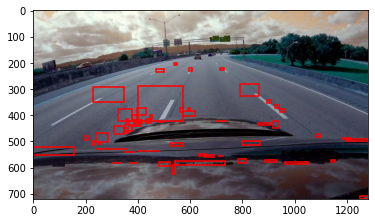

Frame Number :  2


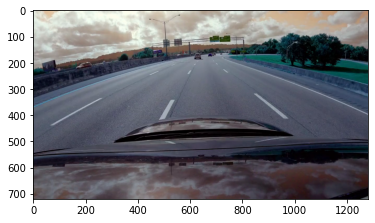

Color Segmentation


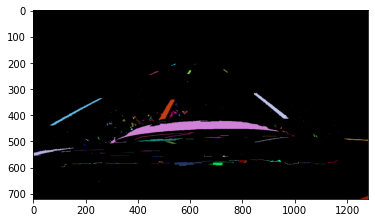

Frame with motion object detection without background


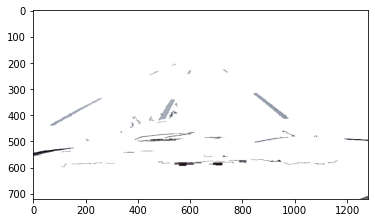

Frame with motion object detection with background


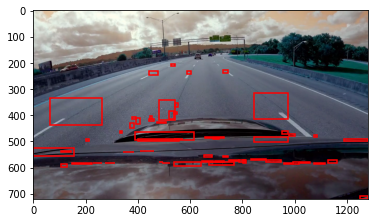

Frame Number :  3


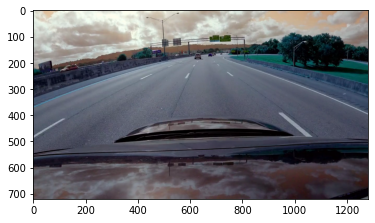

Color Segmentation


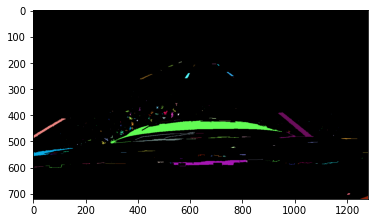

Frame with motion object detection without background


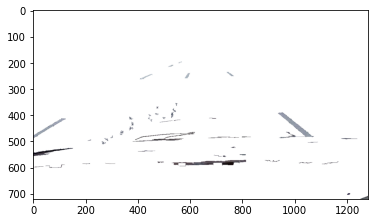

Frame with motion object detection with background


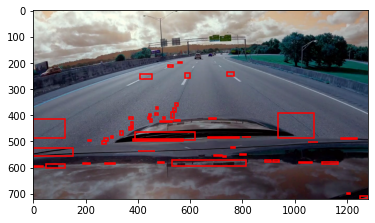

In [ ]:
import random
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import sys
import math
import matplotlib.patches as patch

np.seterr(over='ignore')
os.chdir('data')


# Color Sementation
class RegionGrow():
    def __init__(self, h, w, alpha, beta):
        self.h, self.w = h, w
        self.alpha = alpha
        self.beta = beta
        self.frequency = defaultdict(int)
        self.smallregion = []

        self.im = None
        self.passedBy = np.zeros((self.h, self.w), np.long)
        self.currentRegion = 1
        self.queue = []
        self.SEGS = np.zeros((self.h, self.w, 3), dtype='uint8')

    def getNeighbour(self, x0, y0):
        neighbour = []
        for i in (-1, 0, 1):
            for j in (-1, 0, 1):
                if (i, j) == (0, 0):
                    continue
                x = x0 + i
                y = y0 + j
                if self.limit(x, y):
                    neighbour.append((x, y))
        return neighbour

    def applyRegionGrow(self, frame):
        self.im = frame
        for i in range(0, self.h):
            for j in range(0, self.w):
                self.grown(i, j)
        self.optmization()
        return self.SEGS, self.passedBy, self.currentRegion - 1

    def optmization(self):
        self.regionSize()
        graph = self.adjacentRegions()
        self.optimizedRegions(graph)
        for i in range(0, self.h):
            for j in range(0, self.w):
                if self.passedBy[i, j] == 0: self.splitRegion(i, j)
        for i in range(0, self.h):
            for j in range(0, self.w):
                self.passedBy[i][j] = self.passedBy[i, j] - 1
                val = self.passedBy[i, j]
                self.SEGS[i][j] = val * 35, val * 90, val * 30

    def splitRegion(self, x, y):
        queue = []
        queue.append((x, y))
        while queue:
            x, y = queue.pop(0)
            if self.passedBy[x, y] == 0:
                adjacent = self.getNeighbour(x, y)
                for a, b in adjacent:
                    if self.passedBy[a, b] == 0:
                        queue.append((a, b))
                self.passedBy[x, y] = self.currentRegion
        self.currentRegion += 1

    def printFrame(self):
        plt.imshow(self.SEGS)
        plt.show()

    def grown(self, x0, y0):
        if self.passedBy[x0, y0] == 0 and (
                int(self.im[x0, y0, 0]) * int(self.im[x0, y0, 1]) * int(self.im[x0, y0, 2]) > 0):
            self.passedBy[x0, y0] = self.currentRegion
            self.frequency[self.currentRegion] = 1
            self.queue.append((x0, y0))
            while self.queue:
                x, y = self.queue.pop(0)
                self.BFS(x, y)

            self.currentRegion += 1

    def BFS(self, x0, y0):
        regionNum = self.passedBy[x0, y0]
        elems = []
        elems.append((int(self.im[x0, y0, 0]) + int(self.im[x0, y0, 1]) + int(self.im[x0, y0, 2])) / 3)
        var = self.alpha
        neighbours = self.getNeighbour(x0, y0)

        for x, y in neighbours:
            if self.passedBy[x, y] == 0 and self.distance(x, y, x0, y0) < var:
                self.passedBy[x, y] = regionNum
                self.frequency[self.currentRegion] += 1
                self.queue.append((x, y))
                elems.append((int(self.im[x, y, 0]) + int(self.im[x, y, 1]) + int(self.im[x, y, 2])) / 3)
                var = np.var(elems)
            var = max(var, self.alpha)

    def limit(self, x, y):
        return 0 <= x < self.h and 0 <= y < self.w

    def distance(self, x, y, x0, y0):
        return ((int(self.im[x, y, 0]) - int(self.im[x0, y0, 0])) ** 2 + (
                int(self.im[x, y, 1]) - int(self.im[x0, y0, 1])) ** 2 + (
                        int(self.im[x, y, 2]) - int(self.im[x0, y0, 2])) ** 2) ** 0.5

    def clear(self):
        self.passedBy = np.zeros((self.h, self.w), np.double)
        self.currentRegion = 1
        self.queue = []
        self.SEGS = np.zeros((self.h, self.w, 3), dtype='uint8')

    def regionSize(self):
        self.smallregion = []
        for i in range(1, self.currentRegion):
            if (self.frequency[i] < self.beta): self.smallregion.append(i)

    def adjacentRegions(self):
        graph = defaultdict(set)
        visited = np.full((self.h, self.w), False, dtype=bool)
        queue = []
        queue.append((0, 0))
        while queue:
            a, b = queue.pop(0)
            value = self.passedBy[a, b]
            if visited[a, b] == False:
                neighbours = self.getNeighbour(a, b)
                for x, y in neighbours:
                    k = self.passedBy[x, y]
                    if visited[x, y] == False:
                        queue.append((x, y))
                    if value != k:
                        graph[value].add(k)
            visited[a, b] = True
        return graph

    def optimizedRegions(self, graph):
        visited = [True] * (self.currentRegion)
        mergingRegion = defaultdict(set)
        for region in self.smallregion:
            area = self.frequency[region]
            if area > self.beta: continue
            adjacentregion = graph[region]
            minarea = (self.h * self.w) + 1
            index = 0
            for adjacent in adjacentregion:
                adjacent = int(adjacent)
                if visited[adjacent] == False: continue
                curarea = self.frequency[adjacent]
                if curarea < minarea:
                    minarea = curarea
                    index = adjacent

            if index != 0:
                visited[region] = False
                self.frequency[index] = area + minarea
                mergingRegion[index].add(region)
                for adj in mergingRegion[region]: mergingRegion[index].add(adj)
                for adj in adjacentregion: graph[index].add(adj)

        size = self.currentRegion
        self.currentRegion = 1
        result = defaultdict(int)
        self.frequency = defaultdict(int)
        for k in range(1, size):
            if visited[k] == False:  continue
            result[k] = self.currentRegion
            area = 1
            for adj in mergingRegion[k]:
                result[adj] = self.currentRegion
                area += 1
            self.frequency[self.currentRegion] = area
            self.currentRegion += 1

        for i in range(0, self.h):
            for j in range(0, self.w):
                v = result[self.passedBy[i, j]]
                self.passedBy[i, j] = v


# Spatial Region Graph
class SpatialGraph():

    def __init__(self, totalRegion, regionFrame, colorFrame, frame):
        self.totalRegion = totalRegion
        self.adjacentRegion = defaultdict(set)
        self.regionFrame = regionFrame
        self.h, self.w = self.regionFrame.shape
        self.frame = frame
        self.colorFrame = colorFrame
        self.graphNode = self.getNodes()

        self.labels = None

        self.createSpatialGraph()

    def addEdge(self, src, dest):
        self.adjacentRegion[src].add(dest)
        self.adjacentRegion[dest].add(src)

    class AdjNode():
        def __init__(self, region):
            self.region = region
            self.mvx = -5
            self.mvy = -5
            self.pr = 0
            self.area, self.length, self.height = 0, 0, 0
            self.topX, self.topY, self.bottomX, self.bottomY = -1, -1, -1, -1

        def setArea(self, length, height, area):
            self.length = length
            self.height = height
            self.area = area

        def setPoints(self, topX, topY, bottomX, bottomY):
            self.topX = topX
            self.topY = topY
            self.bottomX = bottomX
            self.bottomY = bottomY

    def getNodes(self):
        hmin, hmax, vmin, vmax = self.coordinatesBox()
        node = [None] * (self.totalRegion)

        for index in range(0, self.totalRegion):
            x = vmin[index]
            y = hmin[index]
            x1 = vmax[index]
            y1 = hmax[index]
            height = x1 - x + 1
            length = y1 - y + 1
            area = length * height
            tempNode = self.AdjNode(index)
            tempNode.setArea(length, height, area)
            tempNode.setPoints(x, y, x1, y1)
            node[index] = tempNode
        return node

    def coordinatesBox(self):
        hmin = {}
        hmax = {}
        vmin = {}
        vmax = {}
        for i in range(0, self.h):
            for j in range(0, self.w):
                value = self.regionFrame[i, j]
                if (value in vmin.keys()) == False:
                    vmin[value] = i
                    vmax[value] = i
                else:
                    if i > vmax[value]:
                        vmax[value] = i

                    if i < vmin[value]:
                        vmin[value] = i

                if (value in hmin.keys()) == False:
                    hmin[value] = j
                    hmax[value] = j
                else:
                    if j > hmax[value]:
                        hmax[value] = j

                    if j < hmin[value]:
                        hmin[value] = j

        return hmin, hmax, vmin, vmax

    def getNeighbour(self, x0, y0):
        neighbour = []
        for i in (-1, 0, 1):
            for j in (-1, 0, 1):
                if (i, j) == (0, 0):
                    continue
                x = x0 + i
                y = y0 + j
                if self.limit(x, y):
                    neighbour.append((x, y))
        return neighbour

    def limit(self, x, y):
        return 0 <= x < self.h and 0 <= y < self.w

    def adjacentRegions(self):
        graph = defaultdict(set)
        visited = np.full((self.h, self.w), False, dtype=bool)

        queue = []
        queue.append((0, 0))

        while queue:
            a, b = queue.pop(0)
            value = self.regionFrame[a, b]
            if visited[a, b] == False:
                neighbours = self.getNeighbour(a, b)
                for x, y in neighbours:
                    k = (int)(self.regionFrame[x, y])
                    if visited[x, y] == False:
                        queue.append((x, y))
                    if value != k:
                        graph[value].add(k)

            visited[a, b] = True

        return graph

    def createSpatialGraph(self):
        adjacentRegion = self.adjacentRegions()

        for num in range(1, self.totalRegion):
            for region in adjacentRegion[num]:
                self.addEdge(num, region)


# Partition Region Matching
class PartitionRegionMatching:
    class MotionVector:

        def __init__(self):
            self.region = -1
            self.minSum = 0
            self.minX = -1
            self.miny = -1
            self.minVector = -1

    def __init__(self, h, w, previousGraph, currentFrame):
        self.h = h
        self.w = w
        self.previousGraph = previousGraph
        self.previousFrame = self.previousGraph.frame
        self.currentFrame = currentFrame
        self.motionEstimation()

    def updateGraph(self):
        return self.previousGraph

    def motionEstimation(self):
        graphNode = self.previousGraph.graphNode

        for index in range(0, self.previousGraph.totalRegion):
            node = graphNode[index]
            topx = node.topX
            topy = node.topY
            bottonx = node.bottomX
            bottomy = node.bottomY
            area = node.area

            if area > 64:
                mvx, mvy, probability = self.motionEstimationUtil(node)
                if probability > 0: node.mvx, node.mvy = mvx, mvy

            else:
                vk, vkx, vky, vp = self.vectorPoints(topx, topy, bottonx + 1, bottomy + 1)
                if vk > 0: node.mvx, node.mvy = vkx, vky

            node.pr = self.motionReliability(node.mvx, node.mvy, topx, topy, bottonx + 1,
                                             bottomy + 1)

            graphNode[index] = node

        self.previousGraph.graphNode = graphNode

    def motionEstimationUtil(self, node):
        length = node.length
        height = node.height

        h, l, eh, el, n = self.splitRegion(height, length)
        row = node.topX
        col = node.topY
        movingRegion = []

        for cnt in range(1, n):
            self.motionVectorUtil(row, col, h, l, movingRegion)
            row += h
            col += l
        self.motionVectorUtil(row, col, eh, el, movingRegion)

        return self.probabilityFunction(movingRegion)

    def motionVectorUtil(self, row, col, h, l, movingRegion):
        vk, vkx, vky, minvp = self.vectorPoints(row, col, row + h, col + l)
        obj = self.MotionVector()
        obj.minX = vkx
        obj.miny = vky
        obj.minSum = vk
        obj.minVector = minvp
        movingRegion.append(obj)

    def vectorPoints(self, x1, y1, x2, y2):
        vk, vkx, vky, vp, cnt = sys.maxsize, -1, -1, -1, 1
        for x in range(-4, 5):
            for y in range(-4, 5):
                cnt += 1
                sum = self.sumAbsoluteDifference(x, y, x1, y1, x2, y2)
                if vk > sum: vk, vkx, vky, vp = sum, x, y, cnt

        return vk, vkx, vky, vp

    def probabilityFunction(self, movingRegion):
        # probability function
        cnt = 1
        mvx = 0
        mvy = 0
        maxprob = 0
        for i in range(-4, 5):
            for j in range(-4, 5):
                cnt += 1
                sum = 0
                for region in movingRegion:
                    if cnt == region.minVector:
                        sum += 1
                sum /= 81
                if sum > maxprob:
                    mvx, mvy = i, j
                    maxprob = sum

        return mvx, mvy, maxprob

    def sumAbsoluteDifference(self, vx, vy, x1, y1, x2, y2):
        sum = 0
        for x0 in range(x1, x2):
            for y0 in range(y1, y2):
                s = x0 + vx
                t = y0 + vy
                if (s < 0 or t < 0 or s >= self.h or t >= self.w): continue
                for z0 in range(0, 3):
                    sum += math.fabs(self.previousFrame[x0, y0, z0] - self.currentFrame[s, t, z0])
        return sum

    def min(self, a, b):
        if a > b:
            return b
        else:
            return a

    def splitRegion(self, height, length):
        a = int(math.sqrt(height))
        b = int(math.sqrt(length))
        subregion = self.min(a, b)

        minlength = int(length / subregion)
        minheight = int(height / subregion)

        extralength = length - (minlength * subregion)
        extraheight = height - (minheight * subregion)

        totalRegion = subregion + 1

        return minheight, minlength, extraheight, extralength, totalRegion

    def motionReliability(self, mvx, mvy, x1, y1, x2, y2):
        numerator = 0
        denominator = self.sumAbsoluteDifference(mvx, mvy, x1, y1, x2, y2) + 1
        for x in range(x1, x2):
            for y in range(y1, y2):
                m = 0
                for i in range(0, 3):
                    temp = math.fabs(self.derivative(1, x, y, i)) + math.fabs(
                        self.derivative(0, x, y, i))
                    m += temp
                numerator += (m / denominator)

        return numerator / denominator

    def derivative(self, wrt, x, y, z):
        if x == 0 or y == 0:
            return self.currentFrame[x, y, z]
        else:
            if wrt == 1:
                return self.currentFrame[x, y, z] - self.currentFrame[x - 1, y, z]
            else:
                return self.currentFrame[x, y, z] - self.currentFrame[x, y - 1, z]


# Markov Random Field - Region level
class MRF:
    def __init__(self, graph):
        self.graph = graph
        self.h, self.w, _ = self.graph.frame.shape
        self.curlabel = 1
        self.stableNodes = 0
        self.labels = [0] * (self.graph.totalRegion)
        self.visited = [False] * (self.graph.totalRegion)
        self.energy = [sys.maxsize] * (self.graph.totalRegion)

    def graphOptmization(self):
        totalNodes = self.graph.totalRegion
        maxRandomNumber = self.graph.totalRegion - 1

        while self.stableNodes != totalNodes:
            index = random.randint(1, maxRandomNumber)
            self.energyFunction(index)

        map = defaultdict(set)
        for index in range(1, self.graph.totalRegion):
            label = self.labels[index]
            map[label].add(index)

        region = 1
        regionMap = defaultdict(set)
        for setvalue in map.values():
            regionMap[region] = setvalue
            region += 1
        self.graph.labels = self.labels

        return regionMap, region, self.graph

    def energyFunction(self, index):

        adjacentRegion = self.graph.adjacentRegion[index]

        u1 = self.U1(index, adjacentRegion)
        u2 = self.U2(index, adjacentRegion)
        for region in self.graph.adjacentRegion[index]:
            if self.labels[index] == self.labels[region]:
                u1 += 1

        u = u1 + u2
        if self.energy[index] > u:
            self.energy[index] = u
            self.stableNodes += 1
            self.curlabel += 1
            self.labels[index] = self.curlabel
            for region in self.graph.adjacentRegion[index]:
                if self.visited[region] == True:
                    self.stableNodes -= 1
                    self.visited[region] = False
                self.labels[region] = self.labels[index]

    def U1(self, index, regions):
        mvx = self.graph.graphNode[index].mvx
        mvy = self.graph.graphNode[index].mvy
        pr = self.graph.graphNode[index].pr
        sum = 0
        for r in regions:
            if self.labels[index] == self.labels[r]:
                mvx1 = self.graph.graphNode[r].mvx
                mvy1 = self.graph.graphNode[r].mvy
                pr1 = self.graph.graphNode[r].pr
                v = self.euclideon(mvx, mvy, mvx1, mvy1) * math.sqrt(pr * pr1)
                sum += v
        return sum

    def U2(self, index, regions):
        node = self.graph.graphNode[index]
        gxa = node.topX + ((node.bottomX - node.topX) / 2)
        gya = node.topY + ((node.bottomY - node.topY) / 2)
        sum = 0
        for r in regions:
            if self.labels[index] == self.labels[r]:
                nodetemp = self.graph.graphNode[r]
                gxb = nodetemp.topX + ((nodetemp.bottomX - nodetemp.topX) / 2)
                gyb = nodetemp.topY + ((nodetemp.bottomY - nodetemp.topY) / 2)
                a = gxa - gxb
                a = a * a
                b = gya - gyb
                b = b * b
                v = 1 / (1 + math.sqrt((a + b)))
                sum -= v

        return sum

    def euclideon(self, mvx, mvy, mvx1, mvy1):
        a = mvx - mvx1
        b = mvy - mvy1
        a = a * a
        b = b * b
        distance = a + b
        return math.sqrt(distance)

    def getNeighbour(self, x0, y0):
        neighbour = []
        for i in (-1, 0, 1):
            for j in (-1, 0, 1):
                if (i, j) == (0, 0):
                    continue
                x = x0 + i
                y = y0 + j
                if self.limit(x, y):
                    neighbour.append((x, y))
        return neighbour

    def limit(self, x, y):
        return 0 <= x < self.h and 0 <= y < self.w


# Moving Object Detection using moving camera

class MovingObjectDetection():
    def __init__(self):
        testdata = self.readfolder()
        index = 1
        for data in testdata:
            firstframe = data[0]
            secondframe = data[1]
            self.detection(index, firstframe, secondframe)
            index += 1

    def readfolder(self):
        testData = []
        classes = 1
        cur_path = os.getcwd()
        for i in range(classes):
            path = os.path.join(cur_path, str(i))
            images = os.listdir(path)
            data = []
            for a in images:
                try:
                    image = Image.open(path + '/' + a)
                    image = np.array(image)
                    data.append(image)
                except Exception as  e:
                    print(e)
            testData.append(data)

        return testData

    def detection(self, curtest, firstframe, secondframe):
        self.height, self.width, _ = firstframe.shape
        alpha = 8
        beta = 32
        object = RegionGrow(self.height, self.width, alpha, beta)

        # Color Segmentation phase1
        colorFrame, regionFrame, totalRegion = object.applyRegionGrow(firstframe)

        # Spatial Graph phase2
        spatialGraph = SpatialGraph(totalRegion, regionFrame, colorFrame, firstframe)

        # Motion Estimation phase3
        motionObject = PartitionRegionMatching(self.height, self.width, spatialGraph, secondframe)

        # update graph after motion estimation
        currentGraph = motionObject.updateGraph()

        # Region Merging Phase 4
        obj = MRF(currentGraph)
        regionMap, totalNodes, currentGraph = obj.graphOptmization()

        # Background Substraction
        optmizedGraph = self.createGraph(totalNodes, currentGraph, regionMap)
        background = self.getBackground(optmizedGraph)

        movingObject = []
        index = 0
        for node in optmizedGraph:
            if background != index:
                if node.area > 64 and node.pr > 0: movingObject.append(node)
            index += 1

        resultframe = self.removeBackground(movingObject, firstframe, regionFrame)

        print('Test %d : ', curtest)
        self.printFrame(firstframe)
        self.printFrame(secondframe)
        print('Result')
        self.printFrame(resultframe)

    def removeBackground(self, movingObject, frame, regionFrame):
        hashset = set()
        for object in movingObject:
            for region in object.regions:
                hashset.add(region)
        resultFrame = np.zeros((self.height, self.width, 3), dtype='uint8')
        for i in range(0, self.height):
            for j in range(0, self.width):
                regionnum = int(regionFrame[i, j])
                if hashset.__contains__(regionnum):
                    resultFrame[i, j] = frame[i, j, 0], frame[i, j, 1], frame[i, j, 2]
                else:
                    resultFrame[i, j] = 255, 255, 255
        return resultFrame

    def createBoxes(self, movingObject, frame):
        fig, ax = plt.subplots(1)
        ax.imshow(frame)
        for object in movingObject:
            rect = patch.Rectangle((object.topy, object.topx), object.length - 1, object.height - 1, linewidth=1.5,
                                   edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()

    def getBackground(self, graph):
        maxarea = 0
        index = 0
        maxindex = -1
        for node in graph:
            if node.area > maxarea:
                maxarea = node.area
                maxindex = index
            index += 1
        return maxindex

    class Node():
        def __init__(self):
            self.regions = set()
            self.topx, self.topy, self.bottomx, self.bottomy = -1, -1, -1, -1
            self.length, self.height, self.area = 0, 0, 0
            self.pr = 1000000
            self.mvx = -10
            self.mvy = -10

    def createGraph(self, totalNodes, graph, label):
        graphNodes = []
        for num in range(1, totalNodes):
            node = self.Node()
            nodes = []
            for reg in label[num]:
                nodetemp = graph.graphNode[reg]
                node.regions.add(reg)
                nodes.append(nodetemp)
                if nodetemp.pr < node.pr:
                    node.pr = nodetemp.pr
                if node.topx == -1:
                    node.topx = nodetemp.topX
                else:
                    node.topx = self.min(node.topx, nodetemp.topX)

                if node.topy == -1:
                    node.topy = nodetemp.topY
                else:
                    node.topy = self.min(node.topy, nodetemp.topY)

                if node.bottomx == -1:
                    node.bottomx = nodetemp.bottomX
                else:
                    node.bottomx = self.max(node.bottomx, nodetemp.bottomX)

                if node.bottomy == -1:
                    node.bottomy = nodetemp.bottomY
                else:
                    node.bottomy = self.max(node.bottomy, nodetemp.bottomY)

            height = (int)(math.fabs(node.topx - node.bottomx)) + 1
            length = (int)(math.fabs(node.topy - node.bottomy)) + 1
            node.area = (int)(length * height)
            node.height = height
            node.length = length
            node.mvx, node.mvy = self.probabilityVector(nodes)
            node.regions = label[num]
            graphNodes.append(node)

        return graphNodes

    def probabilityVector(self, nodes):
        maxprob = 0
        x, y = 0, 0
        for i in range(-4, 5):
            for j in range(-4, 5):
                sum = 0
                for n in nodes:
                    if i == n.mvx and j == n.mvy:
                        sum += 1
                temp = sum / 81
                if temp > maxprob:
                    maxprob = temp
                    x, y = i, j
        return x, y

    def min(self, a, b):
        if a > b: return b
        return a

    def max(self, a, b):
        if a > b: return a
        return b

    def printFrame(self, frame):
        plt.imshow(frame)
        plt.show()


# Run Moving Object Detecton using moving camera
object = MovingObjectDetection()
